![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [55]:
# Import required modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# For lasso
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Run OLS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


# Load and prepare data

First, let's load and examine the data.
We need to make sure that the columns are of the expected data types.



In [56]:
# Load the data
rental_data = pd.read_csv('rental_info.csv')

In [57]:
# Preview the first 5 rows of the data
rental_data.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [58]:
#Examine the data types
rental_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [59]:
rental_data.describe()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100


## Data validation

To run the model, we'll need to calculate the length of each rental. This will serve as our target variable.

However, from the initial examination we see that the date columns ('return_date', 'rental_date') are not in date-time format. We'll need to convert them before calculating the rental length.

Before running a model, we'll also need to transform the 'special_features', creating dummy variables for if a DVD included deleted scenes and/or behind the scenes features.

The 'special_features' column stores its values as a list of strings. We'll have to extract the DVD's that have the above features using some string matching. 

In [60]:
# Create a variable for rental duration and convert to date-time format
rental_data["rental_length"] = pd.to_datetime(rental_data["return_date"]) - pd.to_datetime(rental_data["rental_date"])
rental_data["rental_length_days"] = rental_data["rental_length"].dt.days

# Create dummy variable for the inclusion of deleted scenes 
rental_data["deleted_scenes"] =  np.where(rental_data["special_features"].str.contains("Deleted Scenes"), 1, 0)

# Create dummy variable for the inclusion of behind the scenes
rental_data["behind_the_scenes"] =  np.where(rental_data["special_features"].str.contains("Behind the Scenes"), 1, 0)


## Data cleaning

Lastly, let's see if the data needs any futher cleaning, checking for NA values or outliers.

In [61]:
# Checking for NA values
rental_data.isna().sum()

rental_date           0
return_date           0
amount                0
release_year          0
rental_rate           0
length                0
replacement_cost      0
special_features      0
NC-17                 0
PG                    0
PG-13                 0
R                     0
amount_2              0
length_2              0
rental_rate_2         0
rental_length         0
rental_length_days    0
deleted_scenes        0
behind_the_scenes     0
dtype: int64

In [62]:
# Check for outliers

Q1 = np.percentile(rental_data['rental_length_days'], 25, method='midpoint')
Q3 = np.percentile(rental_data['rental_length_days'], 75, method='midpoint')
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

rental_data_clean = rental_data[(rental_data['rental_length_days'] <= upper) & (rental_data['rental_length_days'] >= lower)] 

print(rental_data.shape)
print(rental_data_clean.shape)

# No outlier detected

(15861, 19)
(15861, 19)


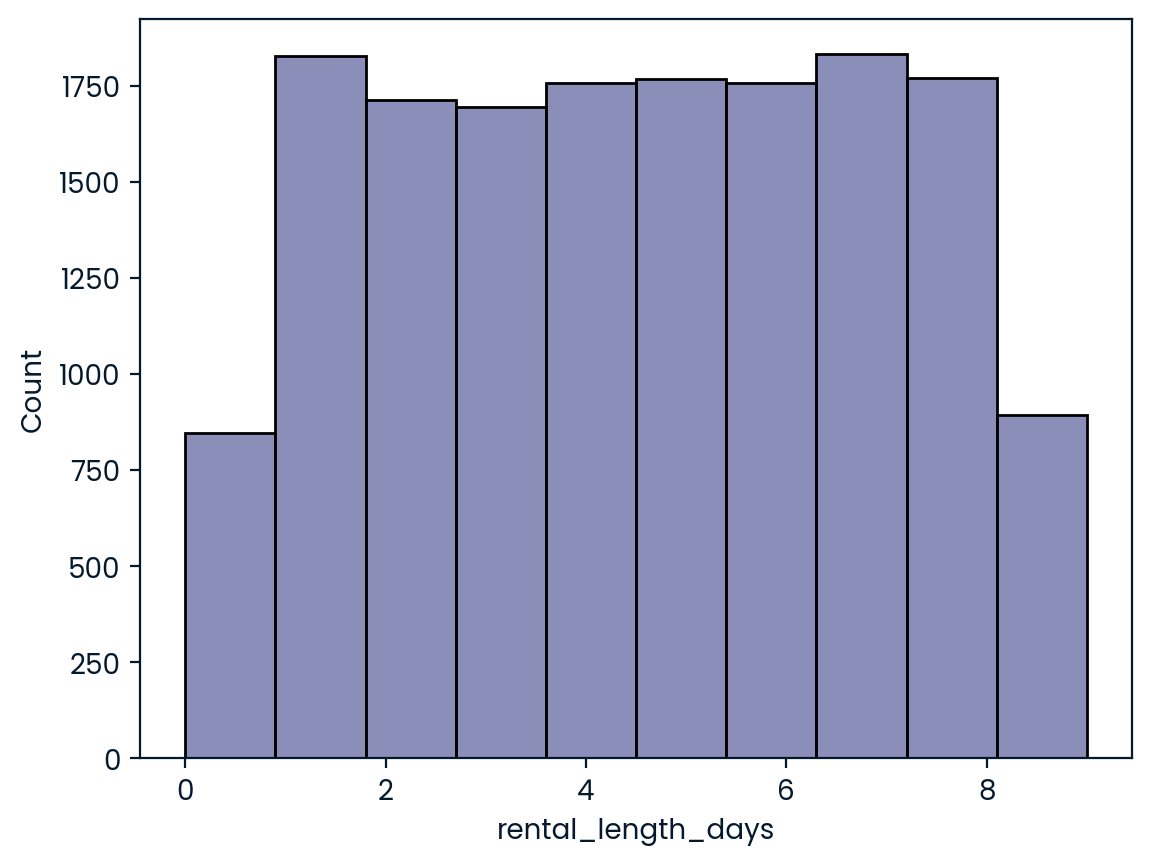

In [63]:
# Visualize the distribution of rental durations

sns.histplot(data=rental_data, x='rental_length_days', bins=10)
plt.show()

# Preparing the model

Now that the data has been validated and cleaned, we can begin building the model.

First we need to split the data into training and test sets, while also dropping columns that could leak data about the target variable ('rental_length_days')

In [64]:
# Choose columns to drop
# These columns are either redundant after the validation process or contain information about the target variable
cols_to_drop = ["special_features", "rental_length", "rental_length_days", "rental_date", "return_date"]

# Split into feature and target sets
X = rental_data_clean.drop(cols_to_drop, axis=1)
y = rental_data_clean["rental_length_days"]

# Further split into training and test data
X_train,X_test,y_train,y_test = train_test_split(X, 
                                                 y, 
                                                 test_size=0.2, 
                                                 random_state=9)


## Feature selection

To determine which features are most informative when predicting rental duration, we'll first run a lasso regression model. The lasso model will force the coefficients of the less informative predictors to zero.

In [65]:
# Create the Lasso model
lasso = Lasso(alpha=0.3, random_state=9) 

# Train the model and access the coefficients
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_

# Perform feature selection by choosing columns with positive coefficients
X_lasso_train, X_lasso_test = X_train.iloc[:, lasso_coef > 0], X_test.iloc[:, lasso_coef > 0]

print(X_lasso_train.columns)


Index(['amount', 'amount_2', 'length_2'], dtype='object')


## The selected features

The results of the lasso model have chosen the following predictor variables:
amount: the rental price of the movie
amount_2: the rental price of the movie squared
length_2: the duration of the movie in minutes squared



# Building the models

Now that we've selected our features, we can begin building a few regression models to compare.
Lets try a linear regression model and a random forest regression model.

## Linear regression model

In [66]:
# Run OLS regression model
ols = LinearRegression()
ols = ols.fit(X_lasso_train, y_train)
y_test_pred = ols.predict(X_lasso_test)
mse_lin_reg_lasso = mean_squared_error(y_test, y_test_pred)

print(mse_lin_reg_lasso)

4.812297241276244


## Random forest regression model

In [67]:
# Random forest hyperparameter space
param_dist = {'n_estimators': np.arange(1,101,1),
          'max_depth':np.arange(1,11,1)}

# Create a random forest regressor
rf = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist, 
                                 cv=5, 
                                 random_state=9)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best hyper param
hyper_params = rand_search.best_params_

# Run the random forest on the chosen hyper parameters
rf = RandomForestRegressor(n_estimators=hyper_params["n_estimators"], 
                           max_depth=hyper_params["max_depth"], 
                           random_state=9)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
mse_random_forest= mean_squared_error(y_test, rf_pred)

print(mse_random_forest)

2.225667528098759


# Model selection

The random forest regression model yielded the lowest mean squared error.

Therefore, we will select it as our best model.


In [68]:
best_model = rf
best_mse = mse_random_forest